# Lagrangian tools using Parcels and xarray

In [1]:
from parcels import FieldSet, Field
from glob import glob
import os
from os.path import join
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cmocean
import gsw
from xgcm.grid import Grid

seconds_per_day = 24*60*60
deg_to_m = 1852 * 60  # m per degree

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../xlcs/")

import lagrangian_tools as lt
import grid_calc
from custommap import *
from contours import extract_contours

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load 7 day-long velocity fields over the Gulf of Mexico

The velocity field, from sea surface height measured by altimetry, was obtained from http://marine.copernicus.eu.

In [6]:
ds0 = xr.open_dataset("1995-01.nc")
ds0

<xarray.Dataset>
Dimensions:    (time: 15, latitude: 171, longitude: 173)
Coordinates:
  * latitude   (latitude) float32 7.375 7.625 7.875 8.125 ... 49.38 49.62 49.88
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-01-15
  * longitude  (longitude) float32 -98.12 -97.88 -97.62 ... -55.62 -55.38 -55.12
Data variables:
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
Attributes: (12/45)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Sea Surface Height measur...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1D
    time_coverage_end:                              2021-08-02T12:00:00Z
    time_coverage_resolution:                       P1D
    time_coverage_start:                            2021-08-01T12:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

## Create grid to easily perform derivative with XGCM
- create grid spacing variable (`dx`, `dy`) with values in meters
- set the coordinates to names recognize by XGCM (`XC`, `YC`, `XG`, `YG`)
    - `XC`, `YC`: The variable values are located at the cell center.
    - `XG`, `YG`: The variable values are located on the cell faces, excluding both outer boundaries.
    - See [Simple Grids](https://xgcm.readthedocs.io/en/latest/grids.html) for more details.
- create the Grid object

In [7]:
ds = ds0.copy(deep=True)


lon, lat = np.meshgrid(ds.longitude, ds.latitude)
ds = (
    # rename previous coordinates
    ds.rename_dims({"latitude": "YC" , "longitude": "XC"})
    .drop_indexes(["longitude", "latitude"])
    
    .assign_coords(
        {"dx": xr.DataArray(
            gsw.distance(lon, lat, axis=1),
            dims=['YC','XG'],
            coords={
                'YC':ds.latitude.data,
                'XG':.5*(ds.longitude.data[1:] + ds.longitude.data[:-1])
            }
        ),
        "dy": xr.DataArray(
            gsw.distance(lon, lat, axis=0),
            dims=['YG','XC'],
            coords={
                'YG':.5*(ds.latitude.data[1:] + ds.latitude.data[:-1]),
                'XC': ds.longitude.data
            }
        )
        }
    )
    # rename velocity variables for simplicity
    .rename_vars({"ugos": "U", "vgos": "V"})
)

In [8]:
ds

<xarray.Dataset>
Dimensions:    (time: 15, YC: 171, XC: 173, XG: 172, YG: 170)
Coordinates:
    latitude   (YC) float32 7.375 7.625 7.875 8.125 ... 49.12 49.38 49.62 49.88
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-01-15
    longitude  (XC) float32 -98.12 -97.88 -97.62 -97.38 ... -55.62 -55.38 -55.12
  * YC         (YC) float32 7.375 7.625 7.875 8.125 ... 49.12 49.38 49.62 49.88
  * XG         (XG) float32 -98.0 -97.75 -97.5 -97.25 ... -55.75 -55.5 -55.25
    dx         (YC, XG) float64 2.757e+04 2.757e+04 ... 1.792e+04 1.792e+04
  * YG         (YG) float32 7.5 7.75 8.0 8.25 8.5 ... 49.0 49.25 49.5 49.75
  * XC         (XC) float32 -98.12 -97.88 -97.62 -97.38 ... -55.62 -55.38 -55.12
    dy         (YG, XC) float64 2.78e+04 2.78e+04 2.78e+04 ... 2.78e+04 2.78e+04
Data variables:
    U          (time, YC, XC) float64 ...
    V          (time, YC, XC) float64 ...
Attributes: (12/45)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Sea Surface Height measur...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1D
    time_coverage_end:                              2021-08-02T12:00:00Z
    time_coverage_resolution:                       P1D
    time_coverage_start:                            2021-08-01T12:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

## XGCM grid object

In [9]:
coords={
        "X": {"center": "XC", "inner": "XG"},
        "Y": {"center": "YC", "inner": "YG"},
       }
grid = Grid(ds, periodic=[], coords=coords)
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> inner
  * inner    XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> inner
  * inner    YG --> center

# OceanParcels input

## Velocity fields to Parcels object

In [10]:
variables = {
    'U': 'U',
    'V': 'U'
}

dimensions = {
    'time': 'time',
    'lon': 'longitude',
    'lat': 'latitude',
}


fs = FieldSet.from_xarray_dataset(ds, variables, dimensions, mesh='spherical')

In [11]:
fs.time_origin

1995-01-01T00:00:00.000000000

## Vorticity

LAVD requires interpolating the vorticity along the trajectories, so we include it as an extra field to the Parcel's fieldset object `fs`.

In [12]:
vg_x = grid.diff(ds.V, 'X', boundary='extend') / ds.dx
ug_y = grid.diff(ds.U, 'Y', boundary='extend') / ds.dy
ds["vorticity"] = (
    grid.interp(vg_x, 'X', to="center", boundary='extend')
  - grid.interp(ug_y, 'Y', to="center", boundary='extend')
)

In [13]:
# add the field to the FS object
field1 = Field.from_xarray(ds["vorticity"], "vorticity", dimensions)
fs.add_field(field1)

## simply to validate the vorticity

/Users/pmiron/micromamba/envs/xlcs/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


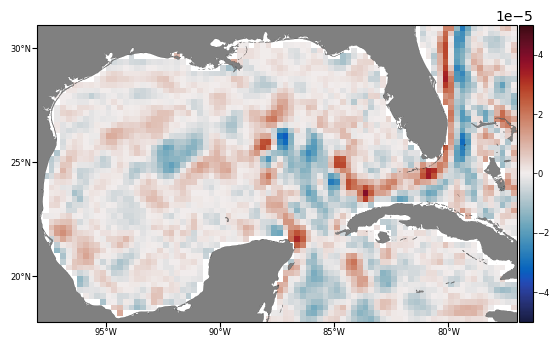

In [18]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())

pcm = ax.pcolormesh(ds.longitude, ds.latitude, ds.vorticity.isel(time=0), cmap=cmocean.cm.balance, vmin=-5e-5, vmax=5e-5)
gom_map(ax)
add_colorbar(fig,ax,pcm)

# Trajectories

In [19]:
# parameters
t0 = datetime(1995,1,15)
adv_time = timedelta(days=6)
adv_dt = -timedelta(hours=12)
pdist = 0.025  # distance in degrees between particles
lon = [-98, -75]
lat = [17, 31]
px = np.arange(lon[0], lon[1]-pdist, pdist)
py = np.arange(lat[0], lat[1]+pdist, pdist)

output_folder = "./"

In [20]:
pset, id0, fm = lt.flowmap_lavd(join(output_folder, f"lavd_{t0.strftime('%Y%m%d')}.zarr"), fs, px, py, t0, adv_time, adv_dt)

INFO: Compiled ArrayLAVDParticleRemoveOnLand ==> /var/folders/_6/hdhmyzr120jgn1d_45q65zkh0000gn/T/parcels-501/lib3c015c97ba0c206aef4acf1e2d5596d2_0.so
INFO: Compiled ArrayLAVDParticleSampleVorticityAdvectionRK4 ==> /var/folders/_6/hdhmyzr120jgn1d_45q65zkh0000gn/T/parcels-501/libe549c249028c4c41496ceaaa397ec940_0.so
100%|█████████████████████████████████████| 518400.0/518400.0 [00:05<00:00, 96001.61it/s]


In [21]:
fm

<xarray.Dataset>
Dimensions:    (YG: 561, XG: 919)
Coordinates:
    longitude  (YG, XG) float64 -98.0 -97.97 -97.95 ... -75.1 -75.07 -75.05
    latitude   (YG, XG) float64 17.0 17.0 17.0 17.0 17.0 ... 31.0 31.0 31.0 31.0
Dimensions without coordinates: YG, XG
Data variables:
    phi_x      (YG, XG) float64 0.0 0.0 0.0 0.0 ... -75.36 -75.31 -75.27 -75.22
    phi_y      (YG, XG) float64 0.0 0.0 0.0 0.0 0.0 ... 30.8 30.82 30.84 30.85
Attributes:
    description:  Flowmap from 1995-01-15 00:00:00 with T = 6 days.

# HERE

In [22]:
# evaluate the Flowmap derivatives to construct the Cauchy-Green tensor
# this is step is not required for the LAVD but we get the Finite-Time Lyapunov Exponent (ftle)
fm = lt.cauchygreen(fm)
lmin, lmax, vmin, vmax, ftle = lt.eigenspectrum(fm.cg.values, adv_time.days*seconds_per_day)

# calculate LAVD from the Parcel's outputs
with xr.open_dataset(join(output_folder, f"lavd_{t0.strftime('%Y%m%d')}.zarr")) as ds_out:
    lavd = lt.lavd(ds_out, np.nanmean(ds["vorticity"]), int(abs(adv_dt.total_seconds())), id0, (len(px), len(py)))

np.savez_compressed(join(output_folder, f"lavd_{t0.strftime('%Y%m%d')}"),
                    lon=fm.longitude.values[:,0],
                    lat=fm.latitude.values[0,:],
                    ftle=ftle,
                    lavd=lavd)

ZeroDivisionError: division by zero

## plot results

In [40]:
folder = './'
data = np.load(join(output_folder, f"lavd_{t0.strftime('%Y%m%d')}.npz"))
lon = data['lon']
lat = data['lat']
ftle = data['ftle']
lavd = data['lavd']

/Users/pmiron/micromamba/envs/xlcs/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


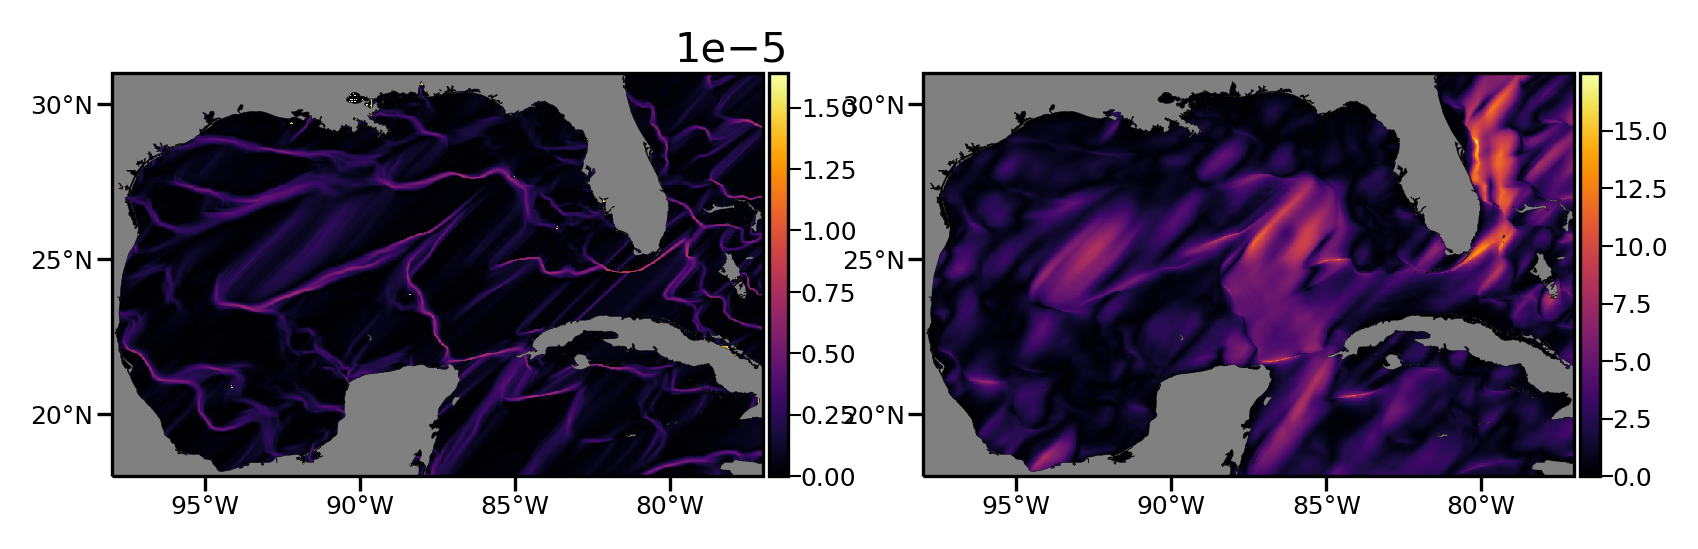

In [42]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1,2,1,aspect='equal', projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1,2,2,aspect='equal', projection=ccrs.PlateCarree())

ftle[ftle<0] = 0  # only positive values are meaningful
pcm = ax1.pcolormesh(lon, lat, ftle.T, cmap='inferno')
gom_map(ax1)
add_colorbar(fig, ax1, pcm)
pcm = ax2.pcolormesh(lon, lat, lavd.T, cmap='inferno')
gom_map(ax2)
add_colorbar(fig, ax2, pcm)

# Extract Contour

In [185]:
# parameters
defTol = 0.075  # [%] control the deficiency of the loop closer to 0 means perfectly convex (~circular)
max_radius = 3  # degree (so ~300 km)

# try extracting contours around each identified peaks
# number_levels represents the number of "test" contour between [0, peak_lavd_value] 
number_levels = 50  

# data
data = np.load(join(folder, f"lavd_{t0.strftime('%Y%m%d')}.npz"))
lon = data['lon']
lat = data['lat']
lavd = data['lavd']

peaks_xy, peaks_contour = extract_contours(lon, lat, lavd, defTol, max_radius, number_levels)
    
#np.save(join(folder, f"peaks_xy_{i:03d}"), peaks_xy)
#np.save(join(folder, f"contours_{i:03d}"), peaks_contour, allow_pickle=True)

/Users/pmiron/Downloads/xlcs/examples/../xlcs/contours.py:23: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
/Users/pmiron/Downloads/xlcs/examples/../xlcs/contours.py:23: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])


## plot contours

/Users/pmiron/micromamba/envs/xlcs/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


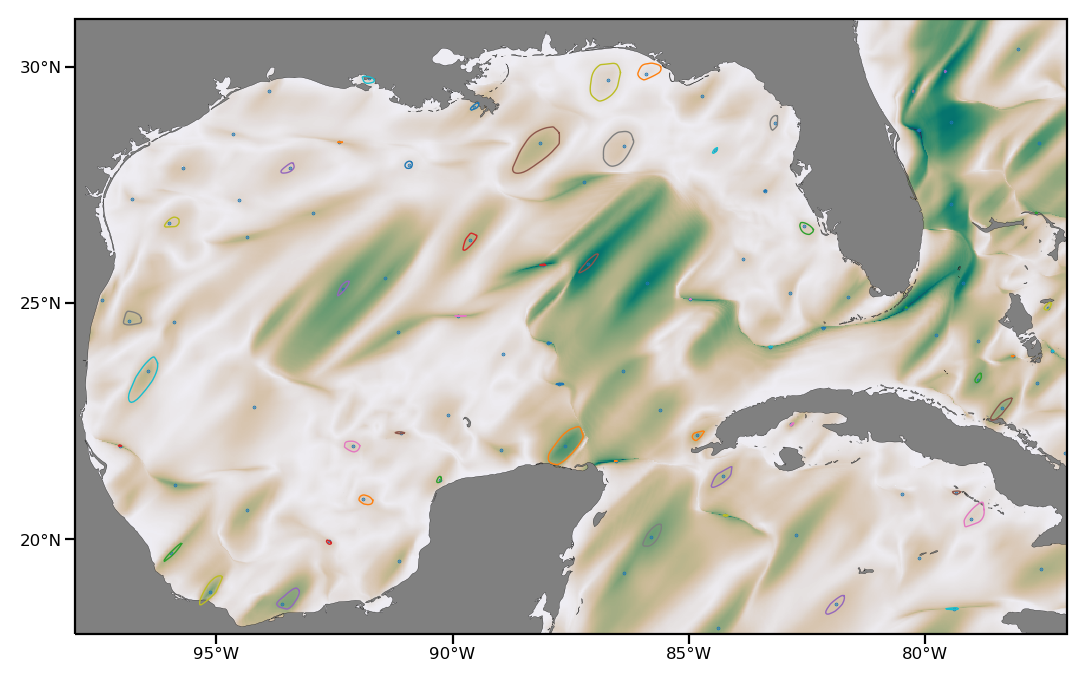

In [186]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())
pcm = ax.pcolormesh(lon, lat, lavd.T, cmap=cmocean.cm.rain)

cc = 0
for c in peaks_contour:
    if c is not None:
        ax.plot(c[:,0], c[:,1], linewidth=0.5)

ax.scatter(lon[peaks_xy[:,0]], lat[peaks_xy[:,1]], s=0.1)
gom_map(ax)